# Latent Dirichlet Allocation (LDA)

LDA это вероятностная тематическая модель. Совместное распределение имеет следующий вид:
$$p(W, Z, \Theta, \Phi | \alpha, \eta) = \prod_{d=1}^D \Big( p(\theta_d | \alpha) \prod_{n=1}^{N_d} p(w_{d,n} | z_{d,n}, \Phi) p(z_{d,n} | \theta_d) \Big) \prod_{t=1}^T p(\phi_t | \eta) $$

Где:
$$p(\theta_d | \alpha) = Dir(\theta_d | \alpha)$$

$$p(w_{d,n} | z_{d,n}, \Phi) = Categorical(W_{d,n} | \phi_{z_{d,n}})$$

$$p(z_{d,n} | \theta_d) = Categorical(z_{d,n} | \theta_d)$$

$$p(\phi_t | \eta) = Dir(\phi_t | \eta)$$

В этой тетрадке мы применим тематическую модель LDA к набору данных NIPS-papers. Нужно установить Python библиотеку `gensim` (её можно установить с помощью `pip`).

In [ ]:
import numpy as np
import scipy.io
from matplotlib import pyplot
%matplotlib inline

import gensim

import logging

gensim.models.ldamodel.logger.setLevel(logging.ERROR)

Для начала нужно скачать данные и поместить их в папку с ноутбуком: 
http://www.cs.nyu.edu/~roweis/data/nips12raw_str602.mat

Код ниже выполняет необходимую предобработку данных.

In [ ]:
nips12 = scipy.io.loadmat('nips12raw_str602.mat', squeeze_me=True)

# матрица размера <число документов> x <число слов>
counts = nips12['counts'].T

# оставим 2013 (~2000) наиболее употребимих слов
words_mask = np.ravel(counts.sum(axis=0) >= 121)
counts = counts[:, words_mask]

# отображение id -> word (необходимо для gensim)
nips12_id2word = {i: w for (i, w) in enumerate(nips12['wl'][words_mask])}

# отображение word -> id (необходимо для pyLDAvis)
nips12_word2id = {w: i for (i, w) in enumerate(nips12['wl'][words_mask])}

# Год проведения конференции. Значение 0 соответсвует 1988, 1 - 1989, и т.д.
nips12_issue = np.array([int(name[4:6]) for name in nips12['docnames']])

# Заголовки статей
nips12_titles = nips12['ptitles']

# Полный корпус в формате gensim
full_corpus = gensim.matutils.Scipy2Corpus(counts)

stream = np.random.RandomState(seed=123)
subset_mask = stream.rand(counts.shape[0]) <= 0.1

# Маленький корпус из 10% случайных статей для ускорения экспериментов
small_corpus = gensim.matutils.Scipy2Corpus(counts[subset_mask, :])

Gensim использует итеративный подход к выводу в модели LDA. Для получения новых значений вариационных параметров выполняется `iterations` итераций вариационного вывода. Далее, новые значения "блэндятся" со старыми (значениями из предыдущей итерации EM-алгоритма) посредством вычисления взвешенного среднего. Эта процедура повторяется `num_passes` раз. Такой подход позволяет предотвратить "застревание" метода в локальных оптимумах.

Обучим модель

In [ ]:
%%time
num_topics = 10  # число тем в модели LDA
alpha = [0.125] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 20  # число итераций вариационного вывода
num_passes = 400  # число проходов по данным

lda = gensim.models.LdaModel(
    corpus=full_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42,    
)

CPU times: user 29min 18s, sys: 1min 1s, total: 30min 20s
Wall time: 29min 32s


In [ ]:
lda.bound(full_corpus)

-13760904.853317022

Извлечем вариационные параметры $\gamma$ &mdash; параметры вариационной аппроксимации апостериорных вероятностей тем для документов: $q(\Theta_d) = Dir(\Theta_d | \gamma_d)$.

Нормализуем их так, чтобы получить вероятностное распределение над темами для каждого документа (средние значения вероятностей в соответствии с распределением Дирихле).

In [ ]:
gamma, _ = lda.inference(full_corpus)
gamma /= np.sum(gamma, axis=1, keepdims=True)

In [ ]:
for topic in range(lda.num_topics):
    print('*' * 80)
    print('Topic %d' % topic)
    print('Words:')
    print('\n'.join(map(str, lda.show_topic(topic))))
    inds = np.argsort(gamma[:, topic])[:-11:-1]
    print('Docs:')
    print('\n'.join(map(str, [(nips12_titles[x], gamma[x, topic]) for x in inds])))
    print()
    

********************************************************************************
Topic 0
Words:
('time', 0.017216519)
('neuron', 0.012411026)
('input', 0.01236177)
('figure', 0.012082619)
('signal', 0.010697149)
('circuit', 0.010274216)
('neurons', 0.009647922)
('analog', 0.0095575135)
('spike', 0.009417974)
('output', 0.009355271)
Docs:
('Temporal Adaptation in a Silicon Auditory Nerve ', 0.9987707)
('A Silicon Model of Amplitude Modulation Detection in the Auditory Brainstem, ', 0.9822309)
('An Analog VLSI Model of Periodicity Extraction,', 0.96427333)
('Silicon Retina with Adaptive Filtering Properties ', 0.96012837)
('Improved Silicon Cochlea Using Compatible Lateral Bipolar Transistors ', 0.9565997)
('A SILICON AXON ', 0.8944925)
('A Systematic Study of the Input/Output Properties of a 2 Compartment Model Neuron With Active Membranes ', 0.86475354)
('An Electronic Photoreceptor Sensitive to Small Changes in Intensity ', 0.8546615)
('Dynamically Adaptable CMOS Winner-Take-All Neura

Вычислим среднюю вероятность тем для каждого года и посмотрим какие темы становятся более популярны с теченим времени, а какие, наоборот, теряют популярность.

In [ ]:
_, years_ids = np.unique(nips12_issue, return_index=True)
years_ids

array([   0,   90,  185,  286,  429,  573,  700,  844,  984, 1136, 1288,
       1439, 1590])

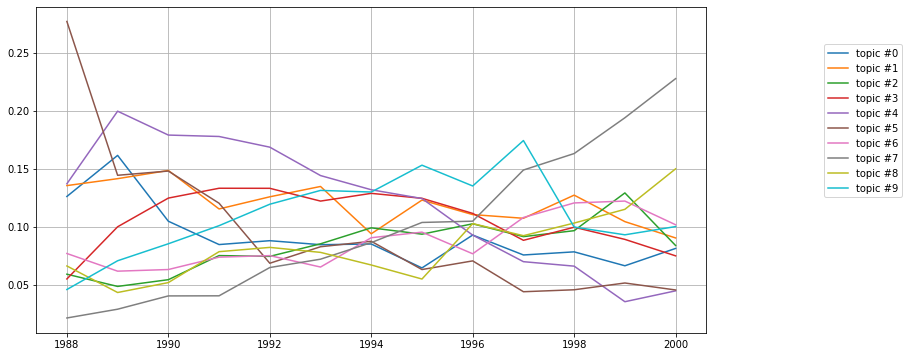

In [ ]:
gmeans = np.zeros([years_ids.size, lda.num_topics])
for i, (lb, rb) in enumerate(zip(years_ids, years_ids[1:].tolist() + [gamma.shape[0]])):    
    gmeans[i, :] = np.mean(gamma[lb:rb], axis=0)
pyplot.figure(figsize=(12, 6))
for i in range(lda.num_topics):
    pyplot.plot(1988 + np.arange(gmeans.shape[0]), gmeans[:, i], label='topic #%d' % i)
pyplot.legend(loc=1, bbox_to_anchor=(1.3, 0.9))
pyplot.grid()
pyplot.show()

In [ ]:
Любопытно посмотреть на темы 4, 5 и 7 =)